Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [1]:
# Imports libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the csv files from part 2 with Foursquare and Yelp EDA
cb = pd.read_csv('../data/cb_montreal_stations.csv')
fsq = pd.read_csv('../data/fsq_bar_features.csv')
yelp = pd.read_csv('../data/yelp_bar_features.csv')

In [3]:
fsq.sort_values(by='name')

,name,postcode,category,distance,latitude,longitude
3969,132 Bar Vintage,H3L 1T4,Cocktail Bar,299.0,45.544079,-73.667357
87,132 Bar Vintage,H3L 1T4,Cocktail Bar,810.0,45.553400,-73.662255
3952,132 Bar Vintage,H3L 1T4,Cocktail Bar,123.0,45.547582,-73.665229
3651,132 Bar Vintage,H3L 1T4,Cocktail Bar,871.0,45.550692,-73.656367
2330,3 Amigos Laval,H7T 2J2,Bar,857.0,45.561570,-73.754480
...,...,...,...,...,...,...
1603,Zoé Fondues-Karaoke,H2A 1W3,Bar,895.0,45.551937,-73.593928
3271,Zoé Fondues-Karaoke,H2A 1W3,Bar,988.0,45.551774,-73.603478
2284,À Domicile,H7T 2K9,Bar,685.0,45.570727,-73.737086
2291,À Domicile,H7T 2K9,Bar,760.0,45.562512,-73.743706


In [4]:
yelp.sort_values(by='name')

,name,postcode,category,review_count,rating,price,distance,latitude,longitude
5921,123 Dzo,H7S 1Z4,Bars,6.0,4.0,NaN,536.542852,45.568420,-73.746873
3245,123 Dzo,H7S 1Z4,Bars,6.0,4.0,NaN,1134.200694,45.565007,-73.731905
3623,123 Dzo,H7S 1Z4,Bars,6.0,4.0,NaN,439.941107,45.570727,-73.737086
6779,Abreuvoir Bar & Terrasse,H2L 1N5,Bars,25.0,4.0,$$,361.475505,45.518206,-73.561619
897,Abreuvoir Bar & Terrasse,H2L 1N5,Bars,25.0,4.0,$$,945.413135,45.524790,-73.565450
...,...,...,...,...,...,...,...,...,...
4879,Über Cafbar,H2C 1P8,Bars,6.0,4.5,$$,113.590897,45.557022,-73.659902
4856,Über Cafbar,H2C 1P8,Bars,6.0,4.5,$$,221.727177,45.559828,-73.658325
7598,Über Cafbar,H2C 1P8,Bars,6.0,4.5,$$,1285.066401,45.549847,-73.647674
4816,Über Cafbar,H2C 1P8,Bars,6.0,4.5,$$,719.766522,45.563872,-73.655568


In [5]:
fsq['name'].nunique()

563

In [6]:
yelp['name'].nunique()

471

A few observations here:

* There are more unique bar names in the 'fsq' dataframe.
* The category of bars from 'fsq' is better categorized, because Foursquare already has a taxonomy of well-define category. We used search string "bars" for categories in the Yelp API call, thus it's not as well-organized. We also added 
* The 'distance' column in Yelp has values greater than 1000m, although we set the radius=1000 only.

For the reasons above, we'll use bar information from Foursquare as the base of our clean data; then add additional information such as 'review_count', 'rating', 'price' from Yelp.

In [7]:
# Merge to add 'review_count', 'rating', 'price' columns from the 'yelp' to 'fsq' dataframe
fsq = fsq.merge(yelp[['name', 'review_count', 'rating', 'price']].drop_duplicates(subset=['name']), on='name', how='left')

In [8]:
# Check again the new 'fsq' dataframe after adding 'review_count', 'rating', 'price' from Yelp
fsq

,name,postcode,category,distance,latitude,longitude,review_count,rating,price
0,Resto-bar Capucine - Nord-Est de Montréal,NaN,Sports Bar,246.0,45.617500,-73.606011,NaN,NaN,NaN
1,Piano Bar la Belle Epoque,H1G 2V6,Cocktail Bar,661.0,45.617500,-73.606011,NaN,NaN,NaN
2,Cafe liana bar & grill,H1E 1M4,Bar,809.0,45.617500,-73.606011,NaN,NaN,NaN
3,La Veranda,H1G 2V5,Bar,960.0,45.617500,-73.606011,NaN,NaN,NaN
4,Le Saint Bock,H2X 3K4,Bar,132.0,45.516926,-73.564257,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5902,La Succursale,H1Y 1Y1,Lounge,607.0,45.545188,-73.576443,25.0,4.0,$$
5903,Pub Rosemont,H2G 1V2,Lounge,797.0,45.545188,-73.576443,NaN,NaN,NaN
5904,Chez Baptiste Sur Masson,H1Y 1X6,Bar,433.0,45.545188,-73.576443,NaN,NaN,NaN
5905,Broue Bar Gaspé,H1Y 1W1,Karaoke Bar,25.0,45.545188,-73.576443,NaN,NaN,NaN


Now, we just need to merge 'fsq' with the Citybikes data in the 'cb' dataframe.

In [9]:
# Merge 'cb' and 'fsq' based on 'cb_latitude' and 'cb_longitude' in 'cb' and 'latitude' and 'longitude' in 'fsq'
merged_all_df = pd.merge(cb, fsq, left_on=['cb_latitude', 'cb_longitude'], right_on=['latitude', 'longitude'], how='inner')

# Drop the repeated 'latitude' and 'longitude' columns from the merged DataFrame
merged_all_df = merged_all_df.drop(['latitude', 'longitude'], axis=1)

merged_all_df

,cb_station_id,cb_station_name,cb_latitude,cb_longitude,cb_bike_num,name,postcode,category,distance,review_count,rating,price
0,72bfd647b3d2b650546f42319729757d,Cégep Marie-Victorin,45.617500,-73.606011,11,Resto-bar Capucine - Nord-Est de Montréal,NaN,Sports Bar,246.0,NaN,NaN,NaN
1,72bfd647b3d2b650546f42319729757d,Cégep Marie-Victorin,45.617500,-73.606011,11,Piano Bar la Belle Epoque,H1G 2V6,Cocktail Bar,661.0,NaN,NaN,NaN
2,72bfd647b3d2b650546f42319729757d,Cégep Marie-Victorin,45.617500,-73.606011,11,Cafe liana bar & grill,H1E 1M4,Bar,809.0,NaN,NaN,NaN
3,72bfd647b3d2b650546f42319729757d,Cégep Marie-Victorin,45.617500,-73.606011,11,La Veranda,H1G 2V5,Bar,960.0,NaN,NaN,NaN
4,36c6491aa1b52e5ef7005f984738de27,Gare d'autocars de Montréal (Berri / Ontario),45.516926,-73.564257,15,Le Saint Bock,H2X 3K4,Bar,132.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5902,6d0a3c1b3a79bb42f1125970e00cd5b1,Parc du Pélican (1ere Ave / Masson),45.545188,-73.576443,39,La Succursale,H1Y 1Y1,Lounge,607.0,25.0,4.0,$$
5903,6d0a3c1b3a79bb42f1125970e00cd5b1,Parc du Pélican (1ere Ave / Masson),45.545188,-73.576443,39,Pub Rosemont,H2G 1V2,Lounge,797.0,NaN,NaN,NaN
5904,6d0a3c1b3a79bb42f1125970e00cd5b1,Parc du Pélican (1ere Ave / Masson),45.545188,-73.576443,39,Chez Baptiste Sur Masson,H1Y 1X6,Bar,433.0,NaN,NaN,NaN
5905,6d0a3c1b3a79bb42f1125970e00cd5b1,Parc du Pélican (1ere Ave / Masson),45.545188,-73.576443,39,Broue Bar Gaspé,H1Y 1W1,Karaoke Bar,25.0,NaN,NaN,NaN


In [10]:
merged_all_df.shape

(5907, 12)

In [11]:
# Save our master dataframe 'merged_all_df' results to csv
merged_all_df.to_csv('../data/merged_all_df.csv', index=False)

### Exploring the data

In [12]:
merged_all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5907 entries, 0 to 5906
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cb_station_id    5907 non-null   object 
 1   cb_station_name  5907 non-null   object 
 2   cb_latitude      5907 non-null   float64
 3   cb_longitude     5907 non-null   float64
 4   cb_bike_num      5907 non-null   int64  
 5   name             5907 non-null   object 
 6   postcode         5726 non-null   object 
 7   category         5907 non-null   object 
 8   distance         5907 non-null   float64
 9   review_count     1757 non-null   float64
 10  rating           1757 non-null   float64
 11  price            1525 non-null   object 
dtypes: float64(5), int64(1), object(6)
memory usage: 599.9+ KB


Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

In [13]:
merged_all_df.describe()

,cb_latitude,cb_longitude,cb_bike_num,distance,review_count,rating
count,5907.000000,5907.000000,5907.000000,5907.00000,1757.000000,1757.000000
mean,45.521242,-73.587392,22.743525,584.92839,75.631759,3.895845
std,0.030818,0.034018,7.579631,255.71585,72.566797,0.512897
min,45.417746,-73.758227,11.000000,5.00000,1.000000,2.000000
25%,45.501863,-73.603984,19.000000,385.00000,20.000000,3.500000
50%,45.523615,-73.579389,23.000000,597.00000,44.000000,4.000000
75%,45.539385,-73.565987,27.000000,801.00000,121.000000,4.000000
max,45.702349,-73.436058,81.000000,1151.00000,388.000000,5.000000


In [14]:
# Add a new column 'unique_name_count' to store the count of unique bars per citybike station in Montreal
merged_all_df['cb_name_count'] = merged_all_df.groupby('cb_station_name')['name'].transform('nunique')

In [15]:
merged_all_df.head()

,cb_station_id,cb_station_name,cb_latitude,cb_longitude,cb_bike_num,name,postcode,category,distance,review_count,rating,price,cb_name_count
0,72bfd647b3d2b650546f42319729757d,Cégep Marie-Victorin,45.617500,-73.606011,11,Resto-bar Capucine - Nord-Est de Montréal,NaN,Sports Bar,246.0,NaN,NaN,NaN,4
1,72bfd647b3d2b650546f42319729757d,Cégep Marie-Victorin,45.617500,-73.606011,11,Piano Bar la Belle Epoque,H1G 2V6,Cocktail Bar,661.0,NaN,NaN,NaN,4
2,72bfd647b3d2b650546f42319729757d,Cégep Marie-Victorin,45.617500,-73.606011,11,Cafe liana bar & grill,H1E 1M4,Bar,809.0,NaN,NaN,NaN,4
3,72bfd647b3d2b650546f42319729757d,Cégep Marie-Victorin,45.617500,-73.606011,11,La Veranda,H1G 2V5,Bar,960.0,NaN,NaN,NaN,4
4,36c6491aa1b52e5ef7005f984738de27,Gare d'autocars de Montréal (Berri / Ontario),45.516926,-73.564257,15,Le Saint Bock,H2X 3K4,Bar,132.0,NaN,NaN,NaN,10


In [16]:
# Check where the missing values are located
merged_all_df.isnull().sum()

cb_station_id         0
cb_station_name       0
cb_latitude           0
cb_longitude          0
cb_bike_num           0
name                  0
postcode            181
category              0
distance              0
review_count       4150
rating             4150
price              4382
cb_name_count         0
dtype: int64

* Treat missing values in 'postcode':

In [17]:
yelp[['name','postcode']].drop_duplicates()

,name,postcode
0,Le 4e Mur,H2X 3K8
1,La Distillerie No.1,H2X 1H6
2,Les Deux Gamins,H2X 1B7
3,Les 3 Brasseurs,H2X 3K6
4,Randolph Pub Ludique,H2X 3K8
...,...,...
7247,La Confrérie,J6W 1E3
7248,La Buvette du Vieux-Terrebonne,J6W 1J9
7959,Le Boudoir Cafe Bar,H2J 1X1
8060,Peroni Resto Bar,H3B


In [18]:
# Create a mapping of 'name' to 'postcode' from the Yelp dataframe above. It has a bigger dataset than Foursquare
unique_yelp_postcode_mapping = yelp[['name', 'postcode']].drop_duplicates().set_index('name')['postcode'].to_dict()

# Use the mapping to fill missing 'postcode' values in merged_all_df
merged_all_df['postcode'].fillna(merged_all_df['name'].map(unique_yelp_postcode_mapping), inplace=True)

In [19]:
merged_all_df['postcode'].isnull().sum()

176

In [20]:
# Fill the rest of 176 missing values in 'postcode' with 'Postcode Unavailable'
merged_all_df['postcode'].fillna('Postcode Unavailable', inplace=True)

* Treat missing values in 'review_count', 'rating':

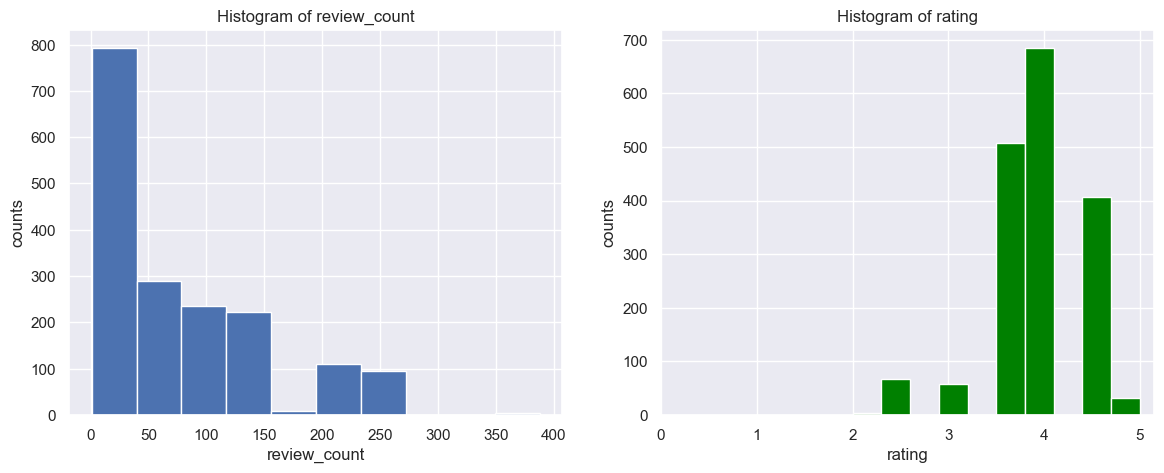

In [21]:
# Create 2 graphs to visualize the distribution of  'review_count' and 'rating':
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Plot 0
axes[0].hist(merged_all_df['review_count'])
axes[0].set_title('Histogram of review_count')
axes[0].set_xlabel('review_count')
axes[0].set_ylabel('counts')

# Plot 1
axes[1].hist(merged_all_df['rating'], color='green')
axes[1].set_title('Histogram of rating')
axes[1].set_xlabel('rating')
axes[1].set_ylabel('counts')
axes[1].set_xlim(left=0)

plt.show()

In [22]:
# As the distributions of these two columns are skewed, we will fill in the missing values with the median.
merged_all_df['review_count'].fillna(merged_all_df['review_count'].median(), inplace=True)
merged_all_df['rating'].fillna(merged_all_df['rating'].median(), inplace=True)

* Treat missing values in 'price':

In [23]:
merged_all_df['price'].value_counts()

$$     1243
$$$     179
$       103
Name: price, dtype: int64

In [24]:
# Calculate the percentage of each price category
(merged_all_df['price'].value_counts() / merged_all_df['price'].notnull().sum()) * 100

$$     81.508197
$$$    11.737705
$       6.754098
Name: price, dtype: float64

In [25]:
# The '$$' value is most populated with >80%, we'll use it to fill in missing values in this column
merged_all_df['price'].fillna('$$', inplace=True)

In [26]:
# Final check for missing values
merged_all_df.isnull().sum()

cb_station_id      0
cb_station_name    0
cb_latitude        0
cb_longitude       0
cb_bike_num        0
name               0
postcode           0
category           0
distance           0
review_count       0
rating             0
price              0
cb_name_count      0
dtype: int64

In [27]:
merged_all_df.shape

(5907, 13)

In [28]:
# Drop duplicates (if any) after treating n/a, but high chance we won't find one because cb_station_id is unique
merged_all_df.drop_duplicates(inplace=True)

### Visualizing the data

In [32]:
merged_all_df.corr()

,cb_latitude,cb_longitude,cb_bike_num,distance,review_count,rating,cb_name_count
cb_latitude,1.000000,-0.028118,-0.171565,0.071032,-0.153997,-0.037010,-0.126527
cb_longitude,-0.028118,1.000000,0.200680,-0.081946,0.128697,-0.025824,0.249523
cb_bike_num,-0.171565,0.200680,1.000000,-0.111890,0.173409,-0.023657,0.151350
distance,0.071032,-0.081946,-0.111890,1.000000,-0.056141,0.029695,-0.108644
review_count,-0.153997,0.128697,0.173409,-0.056141,1.000000,0.244930,0.087457
rating,-0.037010,-0.025824,-0.023657,0.029695,0.244930,1.000000,0.004612
cb_name_count,-0.126527,0.249523,0.151350,-0.108644,0.087457,0.004612,1.000000


<Axes: >

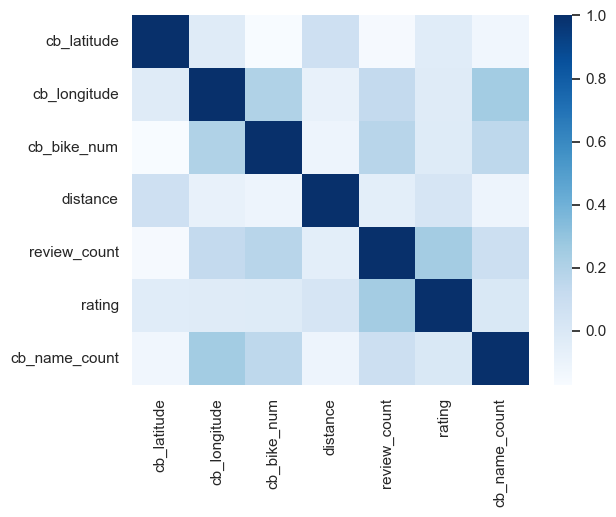

In [31]:
sns.heatmap(merged_all_df.corr(), cmap='Blues')

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

Look at the data before and after the join to validate your data.